In [1]:
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from utils import *
from model import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Using TensorFlow backend.


Load Data

In [46]:
data1 = pd.read_csv("./vgi2.csv")
# data1.index = pd.to_datetime(data1['date'], format='%Y-%m-%d')
data1.head()

,date,close,open,high,low,nmVolume
0,2018-09-25,21.0,21.0,21.0,16.0,1816800.0
1,2018-09-26,23.9,23.9,23.9,23.8,214200.0
2,2018-09-27,27.4,27.4,27.4,27.4,388100.0
3,2018-09-28,28.2,31.5,31.5,27.4,2111074.0
4,2018-10-01,26.8,29.5,29.6,25.8,831097.0


In [47]:
data1 = data1.iloc[1:, :]
data1.head()

,date,close,open,high,low,nmVolume
1,2018-09-26,23.9,23.9,23.9,23.8,214200.0
2,2018-09-27,27.4,27.4,27.4,27.4,388100.0
3,2018-09-28,28.2,31.5,31.5,27.4,2111074.0
4,2018-10-01,26.8,29.5,29.6,25.8,831097.0
5,2018-10-02,26.0,27.1,27.3,25.9,596270.0


Load ARIMA residuals

In [4]:
residuals = pd.read_csv('./ARIMA_residuals1.csv')
residuals.head()  # mất ngày 25

,date,0
0,2018-09-26,2.886284
1,2018-09-27,3.486284
2,2018-09-28,0.786284
3,2018-10-01,-1.413716
4,2018-10-02,-0.813716


Merge Residual with date, close, open, high, low, nmVolume

In [48]:

# residuals.index = pd.to_datetime(residuals['date'])
# residuals.pop('date')
data1 = pd.merge(data1, residuals, on=data1['date'])  # feature engineering bằng cách lấy biến phần dư của mô hình ARIMA
data1.head()

,key_0,date,close,open,high,low,nmVolume,0
0,2018-09-26,2018-09-26,23.9,23.9,23.9,23.8,214200.0,2.886284
1,2018-09-27,2018-09-27,27.4,27.4,27.4,27.4,388100.0,3.486284
2,2018-09-28,2018-09-28,28.2,31.5,31.5,27.4,2111074.0,0.786284
3,2018-10-01,2018-10-01,26.8,29.5,29.6,25.8,831097.0,-1.413716
4,2018-10-02,2018-10-02,26.0,27.1,27.3,25.9,596270.0,-0.813716


In [ ]:
data1.pop('key_0')
data1.set_index('date', inplace=True)

In [51]:
data1.head()

,close,open,high,low,nmVolume,0
date,,,,,,
2018-09-26,23.9,23.9,23.9,23.8,214200.0,2.886284
2018-09-27,27.4,27.4,27.4,27.4,388100.0,3.486284
2018-09-28,28.2,31.5,31.5,27.4,2111074.0,0.786284
2018-10-01,26.8,29.5,29.6,25.8,831097.0,-1.413716
2018-10-02,26.0,27.1,27.3,25.9,596270.0,-0.813716


Spliting Train - Validation - Test

In [52]:
# data = data1.iloc[1:808, :] # train
# data2 = data1.iloc[808:, :] # test
train = data1[data1.index <= '2020-11-24']
valid = data1[(data1.index <= '2021-10-29')&(data1.index > '2020-11-24')]
test_set = data1[(data1.index <= '2021-12-31')&(data1.index > '2021-10-29')]
print('train shape:', train.shape)
print('validation shape:', valid.shape)
print('test shape:', test_set.shape)

train shape: (565, 6)
validation shape: (243, 6)
test shape: (45, 6)


In [121]:
training_set = pd.concat([train, valid], axis=0)
training_set

,close,open,high,low,nmVolume,0
date,,,,,,
2018-09-26,23.9,23.9,23.9,23.8,214200.0,2.886284
2018-09-27,27.4,27.4,27.4,27.4,388100.0,3.486284
2018-09-28,28.2,31.5,31.5,27.4,2111074.0,0.786284
2018-10-01,26.8,29.5,29.6,25.8,831097.0,-1.413716
2018-10-02,26.0,27.1,27.3,25.9,596270.0,-0.813716
...,...,...,...,...,...,...
2021-10-25,36.9,37.9,37.9,36.7,533523.0,-0.613716
2021-10-26,37.4,36.9,37.8,36.6,727721.0,0.486284
2021-10-27,37.5,37.4,37.9,37.3,752737.0,0.086284


Min Max Scale

In [122]:
from sklearn.preprocessing import MinMaxScaler

data_sc = MinMaxScaler()
train_scaled = data_sc.fit_transform(training_set)
valid_scaled = data_sc.transform(valid)
test_set_scaled = data_sc.transform(test_set)


In [123]:
TIME_STEPS = 6


train_close_scaled = train_scaled[:, 0].reshape(len(training_set), 1) # 0 means close
valid_close_scaled = valid_scaled[:, 0].reshape(len(valid), 1) # 0 means close
test_close_scaled = test_set_scaled[:, 0].reshape(len(test_set), 1) # 0 means close


In [22]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

In [20]:
from utils import *

Convert Supervised Data

In [124]:
train_X, _ = create_dataset(train_scaled, TIME_STEPS)
_, train_Y = create_dataset(train_close_scaled, TIME_STEPS) # biến dự đoán close

print(train_X.shape, train_Y.shape)

(802, 6, 6) (802, 1)


In [125]:
valid_X, _ = create_dataset(valid_scaled, TIME_STEPS)
_, valid_Y = create_dataset(valid_close_scaled, TIME_STEPS) # biến dự đoán close

print(valid_X.shape, valid_Y.shape)

(237, 6, 6) (237, 1)


In [126]:
test_X, _ = create_dataset(test_set_scaled, TIME_STEPS)
_, test_Y = create_dataset(test_close_scaled, TIME_STEPS) # biến dự đoán close

print(test_X.shape, test_Y.shape)

(39, 6, 6) (39, 1)


Building Attention-Based CNN-LSTM architecture

In [60]:
def attention_3d_block(inputs, single_attention_vector=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [61]:
def attention_model(INPUT_DIMS = 6,TIME_STEPS = 1,lstm_units = 50): #64
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    # Input()` is used to instantiate a Keras tensor.

    x = Conv1D(filters=50, kernel_size=1, activation='relu')(inputs)  # padding = 'same', filters=64
    x = Dropout(0.2)(x) #0.2

    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # lstm_out = LSTM(lstm_units, return_sequences=True)(x)
    lstm_out = Dropout(0.2)(lstm_out) #0.2
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)  # lấy tích reshape

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

#Training and Save Model

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 6, 6)         0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 6, 50)        350         input_14[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 6, 50)        0           conv1d_14[0][0]                  
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 6, 100)       40400       dropout_27[0][0]                 
___________________________________________________________________________________________

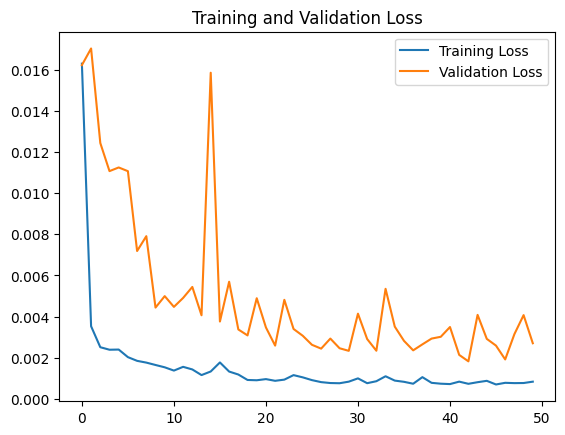

In [128]:
m = attention_model(INPUT_DIMS=6, TIME_STEPS = 6, lstm_units = 50)  #7 number of inputs feature, our data just have 6
m.summary() 
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse') 
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.3)  # validation, 0.3, 
# history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_data=(valid_X, valid_Y))

# X_train: data 5 biến + phần ARIMA redidual
m.save("./stock_model.h5")
np.save("stock_normalize.npy", data_sc)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# time_steps = 1
# lstm_unit = 64. loss: 0.0027 - val_loss: 0.0017, on train scaled
# lstm_unit = 50, cnn_unit = 64. loss: 0.0020 - val_loss: 0.0111
# lstm_unit = 64, cmm_unit = 64 loss: 0.0018 - val_loss: 0.0106
# lstm_unit = 50, cnn_unit = 50 loss: 0.0016 - val_loss: 0.0102

# time_steps = 6
# lstm_unit = 50, cnn_unit = 50 loss: 0.0014 - val_loss: 0.0099

# time_steps = 10
# lstm_unit = 50, cnn_unit = 50 loss: 0.0015 - val_loss: 0.0116

#Load model for prediction

In [129]:
model = attention_model(INPUT_DIMS=6, TIME_STEPS = 6, lstm_units = 50)
model.load_weights('stock_model.h5')
model.summary()
y_hat_test =  model.predict(test_X)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 6, 6)         0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 6, 50)        350         input_15[0][0]                   
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 6, 50)        0           conv1d_15[0][0]                  
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, 6, 100)       40400       dropout_29[0][0]                 
___________________________________________________________________________________________

In [130]:
y_hat_train =  model.predict(train_X)
y_hat_valid =  model.predict(valid_X)

Inverse Min Max Scale

In [131]:
train_min = training_set.min(axis=0)[0]
train_max = training_set.max(axis=0)[0]
print(train_min)
print(train_max)

12.0
47.5


In [133]:
# Train set
y_hat_train_unscaled = y_hat_train*(train_max - train_min) + train_min
y_train_unscaled = train_Y*(train_max - train_min) + train_min

# Valid set
y_hat_valid_unscaled = y_hat_valid*(train_max - train_min) + train_min
y_valid_unscaled = valid_Y*(train_max - train_min) + train_min

# Test set
y_hat_test_unscaled = y_hat_test*(train_max - train_min) + train_min
y_test_unscaled = test_Y*(train_max - train_min) + train_min

Evaluate Performance

In [134]:
print('training evaluate')
y_hat_train_unscaled = np.array(y_hat_train_unscaled, dtype='float64')
y_train_unscaled = np.array(y_train_unscaled, dtype='float64')

evaluation_metric(y_train_unscaled, y_hat_train_unscaled)
# def GetMAPE(y_hat, y_test):
print("MAPE:", GetMAPE(y_hat_train_unscaled, y_train_unscaled), '%')

print('valiation evaluate')

y_hat_valid_unscaled = np.array(y_hat_valid_unscaled, dtype='float64')
y_valid_unscaled = np.array(y_valid_unscaled, dtype='float64')

evaluation_metric(y_valid_unscaled, y_hat_valid_unscaled)
print("MAPE:", GetMAPE(y_hat_valid_unscaled, y_valid_unscaled), '%')

print('test evaluate')

y_hat_test_unscaled = np.array(y_hat_test_unscaled, dtype='float64')
y_test_unscaled = np.array(y_test_unscaled, dtype='float64')

evaluation_metric(y_test_unscaled, y_hat_test_unscaled)
print("MAPE:", GetMAPE(y_hat_test_unscaled, y_test_unscaled), '%')


# training evaluate
# MSE: 1.17529
# RMSE: 1.08411
# MAE: 0.82475
# R2: 0.95080
# MAPE: 3.406122162733455 %
# valiation evaluate
# MSE: 2.28165
# RMSE: 1.51051
# MAE: 1.13895
# R2: 0.77680
# MAPE: 3.725722203746991 %
# test evaluate
# MSE: 0.43780
# RMSE: 0.66167
# MAE: 0.56165
# R2: 0.77915
# MAPE: 2.006565363125627 %

training evaluate
MSE: 1.55952
RMSE: 1.24881
MAE: 0.84189
R2: 0.96578
MAPE: 2.903948211477516 %
valiation evaluate
MSE: 3.46606
RMSE: 1.86174
MAE: 1.32415
R2: 0.82230
MAPE: 3.4934701735959055 %
test evaluate
MSE: 0.50462
RMSE: 0.71036
MAE: 0.52647
R2: 0.86659
MAPE: 1.5550548279661176 %


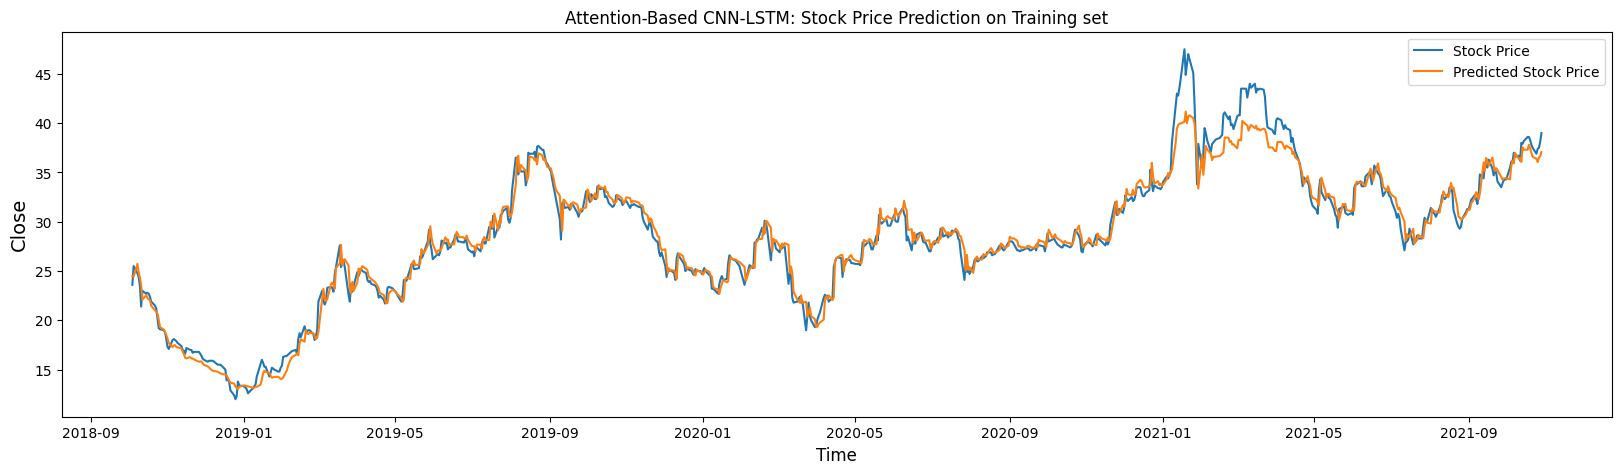

In [144]:
time_train = pd.to_datetime(training_set.index)
TIME_STEPS = 6
time_train = time_train[TIME_STEPS:]


plt.figure(figsize=(20, 5))
plt.plot(time_train, training_set.iloc[TIME_STEPS:, 0], label='Stock Price')
plt.plot(time_train, y_hat_train_unscaled, label='Predicted Stock Price')
plt.title(f'Attention-Based CNN-LSTM: Stock Price Prediction on Training set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

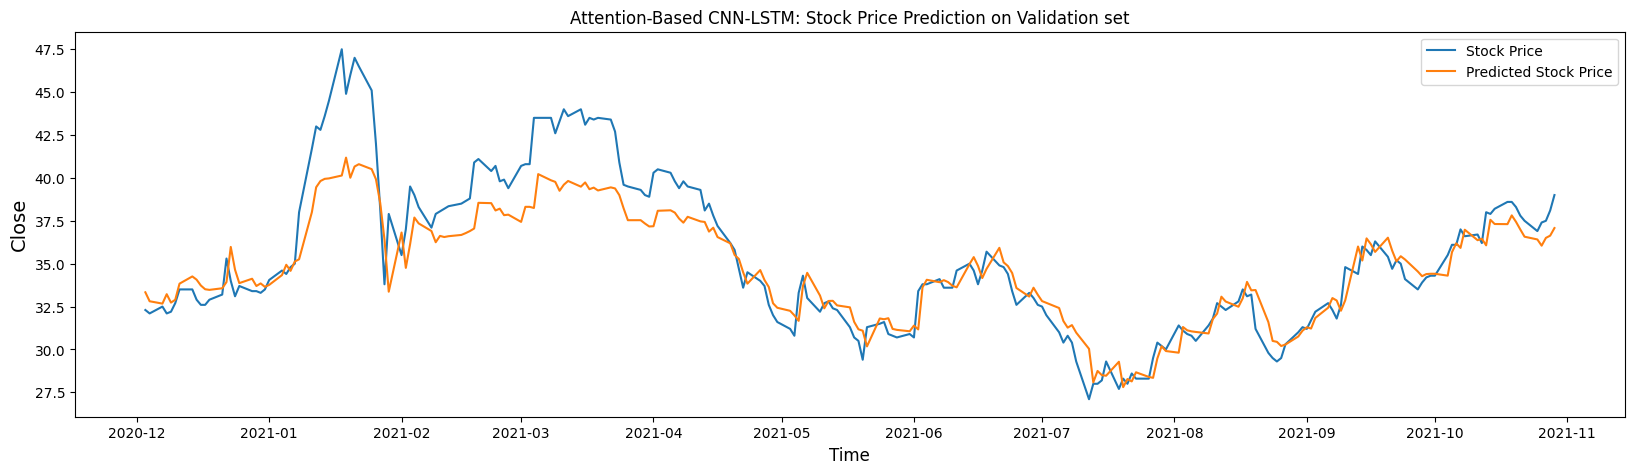

In [143]:
time_valid = pd.to_datetime(valid.index)
TIME_STEPS = 6
time_valid = time_valid[TIME_STEPS:]


plt.figure(figsize=(20, 5))
plt.plot(time_valid, valid.iloc[TIME_STEPS:, 0], label='Stock Price')
plt.plot(time_valid, y_hat_valid_unscaled, label='Predicted Stock Price')
plt.title(f'Attention-Based CNN-LSTM: Stock Price Prediction on Validation set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [135]:
time_test = pd.to_datetime(test_set.index)
TIME_STEPS = 6
time_test = time_test[TIME_STEPS:]
time_test

DatetimeIndex(['2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-22', '2021-11-23', '2021-11-24',
               '2021-11-25', '2021-11-26', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-06',
               '2021-12-07', '2021-12-08', '2021-12-09', '2021-12-10',
               '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', freq=None)

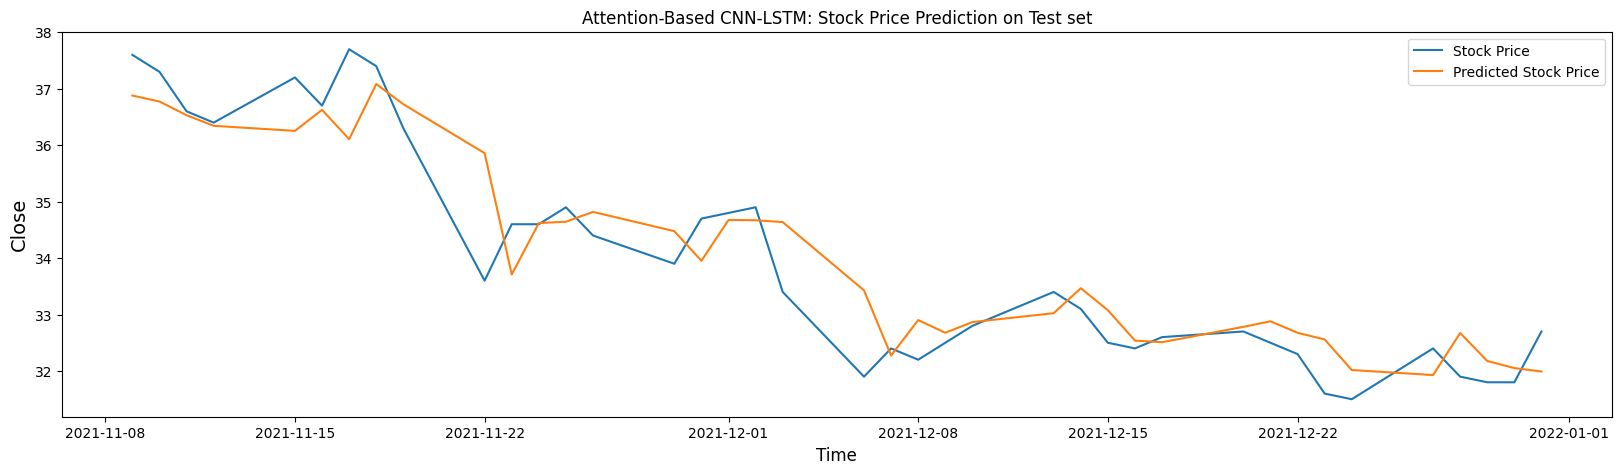

In [140]:
plt.figure(figsize=(20, 5))
plt.plot(time_test, test_set.iloc[TIME_STEPS:, 0], label='Stock Price')
plt.plot(time_test, y_hat_test_unscaled, label='Predicted Stock Price')
plt.title(f'Attention-Based CNN-LSTM: Stock Price Prediction on Test set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()